# Assignment One.
## Irony Detection

# Task 1 (5 Marks)

The data was read into the notebook by using the Pandas package. The length of the vocabulary ignoring case was found to be 17055 words long and the distribution of ironic and non ironic tweets were found to be approximatly equal throught the dataset.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving test.txt to test (3).txt
{'#old+young', 'thts', 'kio', '"come', '#most', '#burst', "friday's", 'http://t.co/uzcna8xiye', 'there#they', ':tired_face::face_with_medical_mask:', '#hybridcloud', 'breathe.', '@seanbhoycfc', 'http://t.co/sudphibdez', 'budget-surveillance', 'nicely:smiling_face_with_smiling_eyes:', 'dumb', 'upgrade', 'ac', '@springthunder', 'iteration', "jolie's", '@falchions', 'resist', 'bag', 'confirme...', 'water.', 'duck', 'http://t.co/c1snyavvdp', '@tritternz', '@cbcjones', 'science', '#vapour', 'hours', 'http://t.co/gvibiz4zsh', 'enhanced', '#it', 'hurts', 'http://t.co/i0txdiptwa', 'plastic', 'signing!', 'concordia', '@pcarsenault', 'bcoz', ':~)', 'way', 'http://t.co/1bjqakjyxl', 'odb', 'teacher.', 'magazine', 'manageable.', 'inflation', 'investigatory', 'ideology:', 'word', 'it...', 'stuff?', '@janeisaacauthor', '#leaders,', 'traffic', 'mass."', 'each', 'religion', 'sick', '34.', '.@jebbush', 'sensible.', '200+', 'shirt.', 'wicked/absurd!', '130km', 'prunes', 'd

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


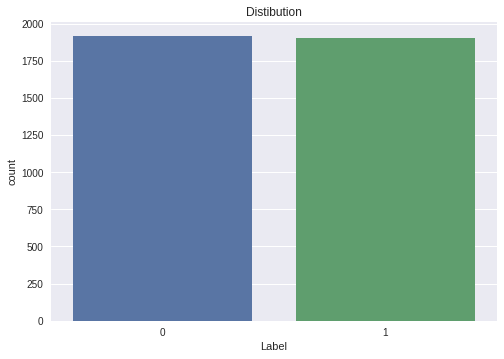

In [60]:
import pandas as pd
import numpy as np
from google.colab import files
import string
import io
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
import math
import re
import seaborn as sns
from copy import copy, deepcopy


uploaded = files.upload()
stopwords = set(stopwords.words('english'))

df = pd.read_csv(io.BytesIO(uploaded['test.txt']),sep='\t',encoding='latin-1') 
df.columns = ['Tweet_index', 'Label','Tweet_text']
copyDF = deepcopy(df)

vocabulary = set()
copyDF['Tweet_text'] = copyDF['Tweet_text'].apply(lambda x: x.lower().strip().split())
copyDF['Tweet_text'].apply(vocabulary.update)

sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Distibution')

print(vocabulary)
print(len(vocabulary))

Each tweet was then processed by removing all capital letters , links to websites and all special characters. The distribution of each feature was first plotted to determine if it could contribute to the classification. All stopwords from the NLTK english library were removed and the words were also stemmed. The reason for this preprocessing was to reduce non relevant data to increase the effiecency of the Naive Bayes and LSTM models.

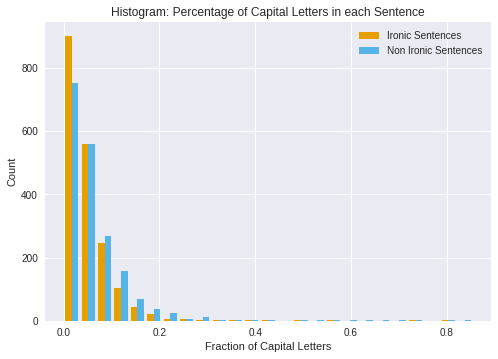

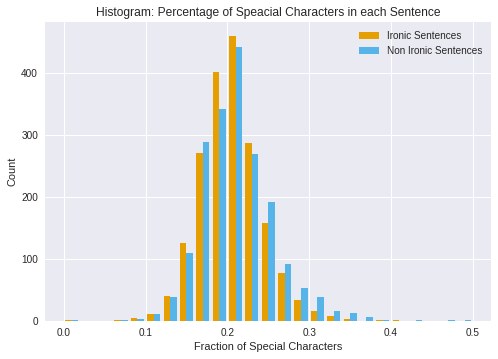

In [61]:
def preprocess(df):
  # remove speacial characters
  ps = PorterStemmer()
  table = str.maketrans('', '', "!$%&\'()*+,-./:;<=>?@[\\]^_`{|}~")
  df['Tweet_text'] = df['Tweet_text'].map(lambda x: x.lower().strip().translate(table))
  # remove any links such as htttp// or www.
  df['Tweet_text'] = df['Tweet_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
  # remove stop words
  df['Tweet_text'] = df['Tweet_text'].apply(lambda x: [item for item in x.split() if item not in stopwords])
  # remove stemmed words.
  df['Tweet_text'] = df['Tweet_text'].apply(lambda x: [ps.stem(w) for w in x])
  return df

def features(df):
  copyDF = deepcopy(df)
  copyDF['Tweet_text_changed'] = copyDF['Tweet_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
  copyDF['Tweet_text_changed'] = copyDF['Tweet_text_changed'].apply(lambda x: x.strip())
  n_ironic = copyDF[copyDF['Label'] == 1]['Tweet_text_changed']
  n_notironic = copyDF[copyDF['Label'] == 0]['Tweet_text_changed']

  # Get the number of capitals in each sentence.
  CapitalsIronic = n_ironic.apply(lambda x: len(re.findall(r'[A-Z]',x))/len(x)).values
  CapitalsNonIronic = n_notironic.apply(lambda x: len(re.findall(r'[A-Z]',x))/len(x)).values

  # Number of Special Characters in each sentence.
  n_ironicSpecial_Characters = n_ironic.apply(lambda x: (len(x) - len(re.findall('[\w]', x)))/len(x)).values
  not_ironicSpecial_Characters = n_notironic.apply(lambda x: (len(x) - len(re.findall('[\w]', x)))/len(x) ).values

  colors = ['#E69F00', '#56B4E9']
  names = ['Ironic Sentences', 'Non Ironic Sentences']
  plt.hist([CapitalsIronic, CapitalsNonIronic], bins = 25, color = colors, label=names)
  plt.legend()
  plt.xlabel('Fraction of Capital Letters')
  plt.ylabel('Count')
  plt.title('Histogram: Percentage of Capital Letters in each Sentence')
  plt.show()

  plt.hist([n_ironicSpecial_Characters, not_ironicSpecial_Characters], bins = 25, color = colors, label=names)
  plt.legend()
  plt.xlabel('Fraction of Special Characters')
  plt.ylabel('Count')
  plt.title('Histogram: Percentage of Speacial Characters in each Sentence')
  plt.show()


features(df)
df = preprocess(df)

The frequency distributions of the top 150 words for both the ironic and non ironic sentences and the top 10 most frequent words from each distribution are plotted below. ''"Love" was the most frequent word found in the ironic distribution whereas the most popular word in the non Ironic distributions was found to be "im"

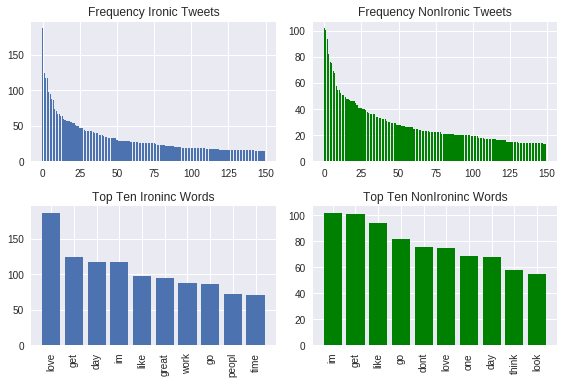

In [62]:
def CountFrequency(my_list):
  # returns a dictionay of the frequency counts sorted by value
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    return(sorted(freq.items(), key=lambda x: x[1],reverse=True))

  
def top_number(df,label,range_): 
  DF = deepcopy(df)
  ironic_words = DF.loc[DF['Label'] == label]['Tweet_text'].values
  ironic_words = [y for x in ironic_words for y in x]
  frequency_ironic_words = CountFrequency(ironic_words)
  return(frequency_ironic_words[0:range_])

top_100_notironic = top_number(df,0,150)
top_100_ironic    = top_number(df,1,150)

top20_notironic = top_number(df,0,10)
top20_ironic    = top_number(df,1,10)

oFig1 = plt.figure(1)
ax1 = oFig1.add_subplot(221)
plt.bar(range(len(top_100_ironic)), [val[1] for val in top_100_ironic], align='center')


ax2 = oFig1.add_subplot(222)
plt.bar(range(len(top_100_notironic)), [val[1] for val in top_100_notironic], align='center', color = 'g')


ax3 = oFig1.add_subplot(223)
plt.bar(range(len(top20_ironic)), [val[1] for val in top20_ironic], align='center')
plt.xticks(range(len(top20_ironic)), [val[0] for val in top20_ironic])
plt.xticks(rotation=90)

ax4 = oFig1.add_subplot(224)
plt.bar(range(len(top20_notironic)), [val[1] for val in top20_notironic], align='center', color = 'g')
plt.xticks(range(len(top20_notironic)), [val[0] for val in top20_notironic])
plt.xticks(rotation=90)
ax1.title.set_text('Frequency Ironic Tweets')
ax2.title.set_text('Frequency NonIronic Tweets')
ax3.title.set_text('Top Ten Ironinc Words')
ax4.title.set_text('Top Ten NonIroninc Words')
oFig1.tight_layout()
plt.show()

# Task 2 (20 Marks)

Develop a classifier using the Naive Bayes model to predict if an example is ironic. The model should convert each Tweet into a bag-of-words and calculate

$p(\text{Ironic}|w_1,\ldots,w_n) \propto \prod_{i=1,\ldots,n} p(w_i \in \text{tweet}| \text{Ironic}) p(\text{Ironic})$

$p(\text{NotIronic}|w_1,\ldots,w_n) \propto \prod_{i=1,\ldots,n} p(w_i \in \text{tweet}| \text{NotIronic}) p(\text{NotIronic})$

You should use add-alpha smoothing to calculate probabilities

The approach taken here was to create a vector representation of each of the sentences using the bag of words model. The frequencies of each word were then calculated for both the ironic and non-ironic sentence in the training set by reducing the n dimensional vector of all the bag of words vectors by its columns. Then a probability vector could be established for each word in the vocabulary using the add one smoothing formula. By using this probability vector and the bag of words representation of the each sentence of the test set the probability of the sentence could be easily calculated by multiplying both vectors together. By removing all the zeros in the resulting vector and then reducing this vector by multiplying each of its elements, the probability of the sentence could easily be found. This value was then multiplied by the class probability and one other value that represented the number of words in the sentence that were not in the original training vocabulary. Their value was calculated using the add one smoothing method.

In [0]:
class Naive_Bayes():

  def train_(self,df):
    
    self.vocabulary = set()
    df['Tweet_text'].apply(self.vocabulary.update)
    df['Bagofwords'] = df['Tweet_text'].apply(lambda x: self.generate_bow(self.vocabulary,x))
    # Number of Ironic 
    n_ironic = df[df['Label'] == 1]['Label'].count()
    # Number of non Ironic
    n_unironic = df[df['Label'] == 0]['Label'].count()
    # Total rows
    total_ironic = df['Label'].count()

    # Probability of ironic
    self.P_ironic = n_ironic/total_ironic

    # Probability of not Ironic
    self.P_not_ironic = n_unironic/total_ironic

    ironic = df.loc[df['Label'] == 1]['Bagofwords'].values
    n_ironic = df.loc[df['Label'] == 0]['Bagofwords'].values

    #get the sum of all columns
    self.column_ironic_words = ironic.sum(axis = 0)
    self.column_non_ironic_words = n_ironic.sum(axis = 0)

    # divide each column by the sum of entire matrix add one smoothing too.
    self.each_ironic_word = (self.column_ironic_words+1)/(self.column_ironic_words.sum()+len(self.vocabulary))
    self.each_nonironic_word = (self.column_non_ironic_words+1)/(self.column_non_ironic_words.sum()+len(self.vocabulary))


  #test
  def predict_sentence(self,sentence):
    # predicts the class of a single sentence.
    missing_vocab_ironic = 1
    missing_vocab_nonironic = 1
    count = 0
    # check if element is in the vocabulary
    # if not calculate the base probability for this value.
    for element in sentence:
      if element not in self.vocabulary:
        missing_vocab_ironic += 1
        missing_vocab_nonironic += 1
        count += 1
    if missing_vocab_ironic > 1:
      missing_vocab_ironic = missing_vocab_ironic*((1)/(self.column_ironic_words.sum()+len(self.vocabulary)))
    if missing_vocab_nonironic >1:
      missing_vocab_nonironic = missing_vocab_nonironic*((1)/(self.column_non_ironic_words.sum()+len(self.vocabulary))) 

    if count == len(sentence):
      testy = self.P_not_ironic*missing_vocab_nonironic
      testx = self.P_ironic*missing_vocab_ironic
    else:
      # generate the bag of words vector for the sentence
      ex = self.generate_bow(self.vocabulary,sentence)

      # mutiple both the probability array and bow together.
      ironic = ex*self.each_ironic_word
      nonironic = ex*self.each_nonironic_word

      # Remove all the zeros and multiple all the values in the array together
      # to get single value
      xx  = list(filter(lambda a: a != 0, ironic))
      yy = list(filter(lambda a: a != 0, nonironic))
      testy = reduce(lambda x, y: x*y, yy)*self.P_not_ironic*missing_vocab_nonironic
      testx = reduce(lambda x, y: x*y, xx)*self.P_ironic*missing_vocab_ironic

    values = np.array([testy, testx])
    class_ = np.argmax(values)
    return(class_)
  
  def generate_bow(self,bag,x):
    # generate a bag of words vector.
    vocab = bag
    bag_vector = np.zeros(len(vocab))
    for w in x:
      for i,word in enumerate(vocab):
        if word == w: 
          bag_vector[i] += 1 
    return(bag_vector)
  
  def predict(self,df):
    df['Newlabel'] = df['Tweet_text'].apply(lambda x: self.predict_sentence(x))
    return(df)



# Task 3 (15 Marks)

Divide the data into a training and test set and justify your split.

Choose a suitable evaluation metric and implement it. Explain why you chose this evaluation metric.

Evaluate the method in Task 2 according to this metric.

As the distribution of ironic and non-ironic sentences are approximately equal the sentences were simply chosen at random with each sentence having the same probability of being chosen. The algorithm creates a random permutation of indices which is then split into the training and testing sample sizes. The corresponding elements are then selected from the data frame and returned to the user.
The automatic evaluation metrics chosen for this project included accuracy, precision, recall and F1 score. These values were computed by first creating a confusion matrix and then preforming the necessary computations to find the metrics. The precision and recall were chosen to appear alongside the accuracy of the model as they essentially return a more adequate representation of the performance of a model when faced imbalanced classification tasks.


(0.6384279475982533, 0.6967592592592593, 0.5154109589041096, 0.5925196850393701)


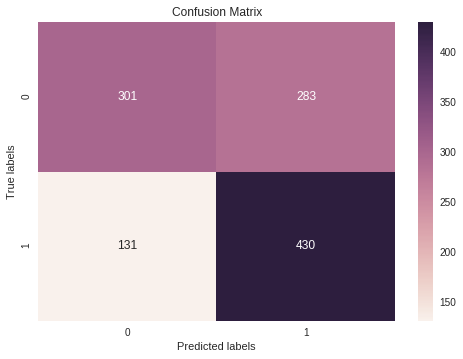

In [64]:
def My_train_test_split(df, train_percent, test_percent):
    # calculate random permutation of indices
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    test_end = int(test_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:test_end]]
    return(train.reset_index(drop=True), test.reset_index(drop=True))

  
def Confusion_Metrics(cm_matrix):
  cm_matrix = np.asarray(cm_matrix)
  rows = cm_matrix.sum(axis=1)
  columns = cm_matrix.sum(axis=0)
  total = cm_matrix.sum()
  TP = []
  FN = []
  FP = []
  TN = []
  acurracy    = []
  precision   = []
  Recall      = []
  F1score     = []
  for i in range(len(cm_matrix)):
    TP.append(cm_matrix[i][i])
    FN.append(rows[i]-TP[i])
    FP.append(columns[i]-TP[i])
    TN.append(total-rows[i]-columns[i]+TP[i])
    acurracy.append((TP[i]+TN[i])/(TP[i]+FP[i]+FN[i]+TN[i]))
    precision.append((TP[i])/(TP[i]+FP[i]))
    Recall.append((TP[i])/(TP[i]+FN[i]))
    F1score.append((2*precision[i]*Recall[i])/(precision[i]+Recall[i]))
  return(acurracy[0],precision[0],Recall[0],F1score[0])
          
def Plot(cm_matrix):
  ax= plt.subplot()
  sns.heatmap(cm_matrix, annot=True, ax = ax,fmt='g')
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix') 
  plt.show()      

def compute_confusion_matrix(true, pred):
  K = len(np.unique(true))
  result = np.zeros((K, K))
  for i in range(len(true)):
    result[true[i]][pred[i]] += 1
  return result
 
train, test = My_train_test_split(df,.7, .3)
naive_bayes = Naive_Bayes()
naive_bayes.train_(train)
test = naive_bayes.predict(test)
CM = compute_confusion_matrix(test['Label'].values, test['Newlabel'].values)
print(Confusion_Metrics(CM))
Plot(CM)

# Task 4 (20 Marks)

Run the following code to generate a model from your training set. The training set should be in a variable  called `train` and is assumed to be of the form:

```
[(1, 1, ['sweet', 'united', 'nations', 'video', '.', 'just', 'in', 'time', 'for', 'christmas', '.', '#', 'imagine', '#', 'noreligion', 'http', ':', '//t.co/fej2v3oubr']), 
 (2, 1, ['@', 'mrdahl87', 'we', 'are', 'rumored', 'to', 'have', 'talked', 'to', 'erv', "'s", 'agent', '...', 'and', 'the', 'angels', 'asked', 'about', 'ed', 'escobar', '...', 'that', "'s", 'hardly', 'nothing', ';', ')']), 
 (3, 1, ['hey', 'there', '!', 'nice', 'to', 'see', 'you', 'minnesota/nd', 'winter', 'weather']), 
 (4, 0, ['3', 'episodes', 'left', 'i', "'m", 'dying', 'over', 'here']), 
 ...
]
 ```



In [65]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np

test.pop('Newlabel')
train.pop('Bagofwords')

## These values should be set from Task 3
train,test = train.values,test.values

def make_dictionary(train, test):
    dictionary = {}
    for d in np.concatenate([train,test]):
        for w in d[2]:
            if w not in dictionary:
                dictionary[w] = len(dictionary)
    return dictionary

class KerasBatchGenerator(object):
    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.current_idx = 0
        self.current_sent = 0
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, 2))
        while True:
            for i in range(self.batch_size):
                # Choose a sentence and position with at lest num_steps more words
                while self.current_idx + self.num_steps >= len(self.data[self.current_sent][2]):
                    self.current_idx = self.current_idx % len(self.data[self.current_sent][2])
                    self.current_sent += 1
                    if self.current_sent >= len(self.data):
                        self.current_sent = 0
                # The rows of x are set to values like [1,2,3,4,5]
                x[i, :] = [self.vocabulary[w] for w in self.data[self.current_sent][2][self.current_idx:self.current_idx + self.num_steps]]
                # The rows of y are set to values like [[1,0],[1,0],[1,0],[1,0],[1,0]]
                y[i, :, :] = [[self.data[self.current_sent][1], 1-self.data[self.current_sent][1]]] * self.num_steps
                self.current_idx += self.skip_step
            yield x, y,

# Hyperparameters for model
vocabulary = make_dictionary(train, test)
num_steps = 5
batch_size = 20
num_epochs = 50 # Reduce this if the model is taking too long to train (or increase for performance)
hidden_size = 50 # Increase this to improve perfomance (or increase for performance)
use_dropout=True

# Create batches for RNN
train_data_generator = KerasBatchGenerator(train, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(test, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

# A double stacked LSTM with dropout and n hidden layers
model = Sequential()
model.add(Embedding(len(vocabulary), hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(2)))
model.add(Activation('softmax'))

# Set optimizer and build model
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Train the model
model.fit_generator(train_data_generator.generate(), len(train)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(test)//(batch_size*num_steps))

# Save the model
model.save("final_model.hdf5")

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
26/26 [==============================] - 7s 273ms/step - loss: 0.6944 - categorical_accuracy: 0.4923 - val_loss: 0.6943 - val_categorical_accuracy: 0.4264
Epoch 2/50
26/26 [==============================] - 1s 21ms/step - loss: 0.6918 - categorical_accuracy: 0.5281 - val_loss: 0.6922 - val_categorical_accuracy: 0.5327
Epoch 3/50
26/26 [==============================] - 1s 20ms/step - loss: 0.6873 - categorical_accuracy: 0.5315 - val_loss: 0.6917 - val_categorical_accuracy: 0.5118
Epoch 4/50
26/26 [==============================] - 1s 21ms/step - loss: 0.5860 - categorical_accuracy: 0.7885 - val_loss: 0.9017 - val_categorical_accuracy: 0.5318
Epoch 5/50
26/26 [==============================] - 1s 21ms/step - loss: 0.5198 - categorical_accuracy: 0.8185 - val_loss: 0.8027 - val_categorical_accuracy: 0.5155
Epoch 6/50
26/26 [==============================] - 1s 21ms/step - loss: 0.3505 - categorical_ac

Initially I tried to utilize the batch generator to break the test data into the necessary input format. However, in order to compute the accuracy using the metrics described in part three the label of the current sentence has to be known, therefore an original function would have to be written to replicate the batch generator. From my understanding the model takes a sequence of 5 tokenised words as an input and then gives the probability that each word in the sequence/ next word in the sequence is  either ironic or not. A sliding window that cycles through the entire sentence was used to break the sentence down into sequences of 5. Next as there was an overlap between sequences, some words will be have a larger impact on the overall classification result thus a mask matrix was created that represented the inverse frequency of each word in the sequences. Each word was tokenized and the corresponding probabilities were calculated these values were then multiplied with the mask matrix and the following correct matrix was reduced by the product of each of its column. This created a vector with the two elements representing the probability of the sentence being either ironic or not ironic, the maximum value between them represented the class of the sentence. The corresponding accuracy seems to range from around 52%-57%.

(0.5718717683557394, 0.5782312925170068, 0.6719367588932806, 0.6215722120658135)


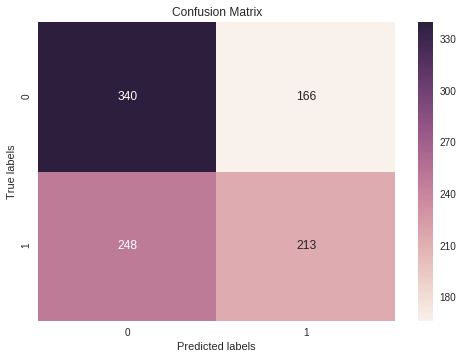

In [66]:
def CountFrequency(my_list):
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    return(freq)

def batch_predict(a):
  # apply sliding window.
  b = [a[i:i+5] for i in range(len(a)-4)]
  # flatten array
  flat = [y for x in b for y in x]
  # create dictionary of the frequency of each element
  dictionary = CountFrequency(flat)
  weights = np.zeros((len(b),5))
  x = np.zeros((len(b),5))
  # create a mask array to multiply each word by inverse of the frequency.
  for i in range(len(b)):
    for j in range(len(b[i])):
      x[i][j] = vocabulary[b[i][j]]
      weights[i][j] = (1/dictionary[b[i][j]])

  # predict the values of each word and multiply each one by the the appropriate 
  # weighted matrix.
  ans = np.array([model.predict(list_.reshape(1,5)) for list_ in x])
  final_array = []
  for i in range(len(weights)):
    for j in range(5):
      final_array.append(ans[i][0][j]*weights[i][j])
  
  # reduce this matrix by the product of each comlumn then return the 
  # class of the sentence by the position of the smallest object.
  ans = np.array(final_array)    
  temp = np.prod(ans, axis=0)
  return(np.argmin(temp))

test_df = pd.DataFrame({'Label':test[:,1],'Tweet':test[:,2]})
# Filter any Tweets with less than 5 words.
test_df['Length'] = test_df['Tweet'].apply(lambda x: len(x))
test_df = test_df[test_df['Length'] >= 5]
# use lambda method to apply function to every sentence in the test data
test_df['Newlabel'] = test_df['Tweet'].apply(lambda x: batch_predict(x))

CM = compute_confusion_matrix(test_df['Label'].values, test_df['Newlabel'].values)
print(Confusion_Metrics(CM))
Plot(CM)

# Task 5 (40 Marks)

Suggest an improvement to either the system developed in Task 2 or 4 and show that it improves according to your evaluation metric.

Please note this task is marked according to: demonstration of knowledge from the lecutures (10), originality and appropriateness of solution (10), completeness of description (10), technical correctness (5) and improvement in evaluation metric (5).

The inherent problem with the model from task four is that the classification model over fits the training data and the fact that the model only classifies a single word at a time is inefficient for the task of text classification. To combat these issues each sentence in the training corpus was extended to the max length in the training corpus. This was achieved using the padding function provided by Scikit learn which bulks up the vectors by turning them into sparse vectors by adding the necessary number of zeros to bring the vector to the desired length. As the model learns sequentially this new universal vector length was used as the number of steps for our model and the target was the label of each sentence. The previous embedding layer used a one hot encoded sparse vector representation to increase the efficiency of the model this representation was replaced with word2vec word embedding.  As the twitter data had a number of unique words. The Word2vec model had to be trained on our original corpus, this was achieved using the genism package in python. These two amendments instantly increased the models accuracy, however the model still exhibited extreme variance. Ideally, to reduce this we would increase the training data size. As this was not possible I attempted to reduce the capacity of the model ie. The size of the hidden units and embedding space until it no longer over fits. None of these attempts drastically reduced the overfitting problem and the fact that the model accuracy seems to plateau at comparable result to the Naïve Bayes classifier suggested that it had reached its potential. Essentially the two layered LSTM is just too complex for this small dataset.


In [67]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.layers import Embedding
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed,Flatten, SpatialDropout1D
from keras.layers import LSTM, GRU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras import regularizers

MAX_NB_WORDS = 2000000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

# define training data
sentences = df['Tweet_text'].values
# train model
Word2Vecmodel = Word2Vec(sentences, size=100, window=6, min_count=1, workers=4)
# summarize the loaded model
print(Word2Vecmodel)
# summarize vocabulary
words = list(Word2Vecmodel.wv.vocab)
print(words)

Word2Vec(vocab=11580, size=100, alpha=0.025)
['sweet', 'unit', 'nation', 'video', 'time', 'christma', '#imagin', '#noreligion', 'mrdahl87', 'rumor', 'talk', 'erv', 'agent', 'angel', 'ask', 'ed', 'escobar', 'that', 'hardli', 'noth', 'hey', 'nice', 'see', 'minnesotand', 'winter', 'weather', '3', 'episod', 'left', 'im', 'die', 'cant', 'breath', 'chosen', 'notabl', 'quot', 'year', 'annual', 'list', 'releas', 'yale', 'univers', 'librarian', 'your', 'never', 'old', 'footi', 'pajama', 'make', 'happier', 'get', 'highway', 'break', 'light', 'like', 'tree', '430', 'open', 'first', 'beer', 'gonna', 'long', 'nightday', 'adamklug', 'think', 'would', 'support', 'guy', 'knock', 'daughter', 'rice', 'doesnt', 'deserv', 'samcguigan544', 'allow', 'day', 'oh', 'thank', 'god', 'entir', 'offic', 'email', 'system', 'big', 'event', 'santa', 'know', 'xma', 'instead', 'scroll', 'facebook', 'instagram', 'twitter', 'hour', 'end', 'accomplish', 'targetzonept', 'poutingfac', 'bloodi', 'isnt', 'upstair', 'chang', 'c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


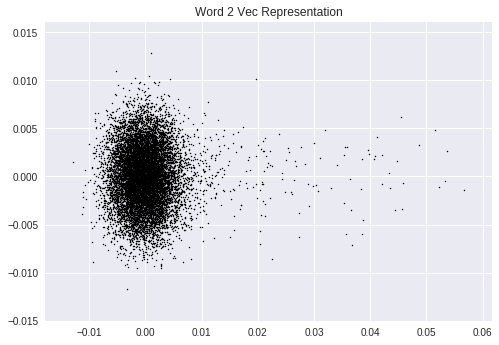

In [68]:
X = Word2Vecmodel[Word2Vecmodel.wv.vocab]
# dimensionality reduction
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the new projection
plt.scatter(result[:, 0], result[:, 1], s = 1.25, c='k')
plt.title('Word 2 Vec Representation')
plt.show()

In [69]:
X = df.Tweet_text
Y = df.Label
Y = Y.values.reshape(-1,1)

# split train test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4)

# Tokenise the padded sequences.
tok = Tokenizer(num_words=MAX_NB_WORDS)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)

word_index = tok.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1


embedding_matrix = Word2Vecmodel.wv.vectors
# Create embedding layer with word embedding vectors from word2vec
embedding_layer = Embedding(embedding_matrix.shape[0], 
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,dropout=0.5)

# Create the same model as before with added dropouts a flattening layer was also needed to 
# confrom the input to the right shape.
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(40, return_sequences=True,recurrent_dropout=0.2))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(40, return_sequences=True,recurrent_dropout=0.2))
model.add(SpatialDropout1D(0.25))
model.add(TimeDistributed(Dense(2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer= RMSprop(), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 50, 100)           1158000   
_________________________________________________________________
dropout_32 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 50, 40)            22560     
_________________________________________________________________
spatial_dropout1d_25 (Spatia (None, 50, 40)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50, 40)            12960     
_________________________________________________________________
spatial_dropout1d_26 (Spatia (None, 50, 40)            0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 50, 2)             82        
__________

In [70]:
history = model.fit(sequences_matrix, Y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_split=0.1)

Train on 2061 samples, validate on 229 samples
Epoch 1/10
2061/2061 [==============================] - 11s 5ms/step - loss: 0.6941 - acc: 0.5032 - val_loss: 0.6929 - val_acc: 0.5022
Epoch 2/10
2061/2061 [==============================] - 3s 1ms/step - loss: 0.6906 - acc: 0.5497 - val_loss: 0.6924 - val_acc: 0.5022
Epoch 3/10
2061/2061 [==============================] - 3s 1ms/step - loss: 0.6832 - acc: 0.5934 - val_loss: 0.6844 - val_acc: 0.5502
Epoch 4/10
2061/2061 [==============================] - 3s 1ms/step - loss: 0.6265 - acc: 0.6977 - val_loss: 0.6591 - val_acc: 0.6114
Epoch 5/10
2061/2061 [==============================] - 3s 1ms/step - loss: 0.4940 - acc: 0.8049 - val_loss: 0.6657 - val_acc: 0.6419
Epoch 6/10
2061/2061 [==============================] - 3s 1ms/step - loss: 0.3730 - acc: 0.8418 - val_loss: 0.7294 - val_acc: 0.6463
Epoch 7/10
2061/2061 [==============================] - 3s 1ms/step - loss: 0.2838 - acc: 0.8894 - val_loss: 0.8072 - val_acc: 0.6419
Epoch 8/10
206

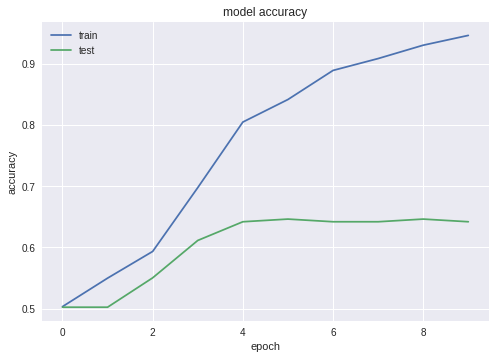

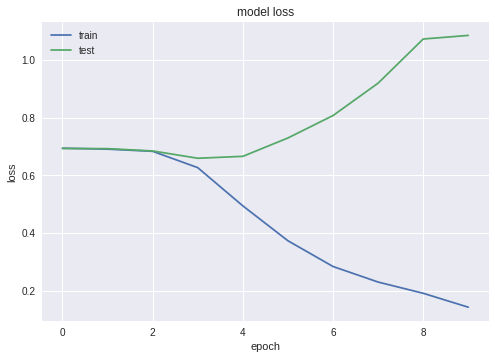

In [71]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(0.6136214800261951, 0.6122448979591837, 0.5960264900662252, 0.6040268456375839)


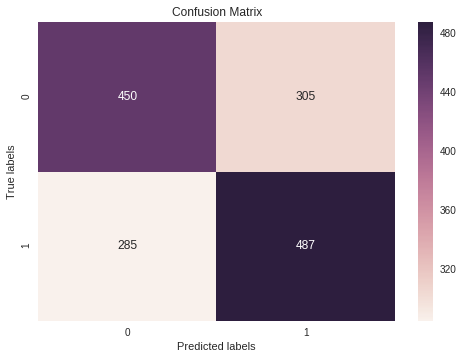

In [72]:
# pad test sequence
# as the output is from a sigmoid layer
# predictions needed to be flattened
# needs to be converted to labels
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)
Predictions = list(map(lambda x: model.predict(x.reshape(1,50)), test_sequences_matrix))
Predictions = [y for x in Predictions for y in x]
Predictions =[y for x in Predictions for y in x]
Predictions_flat = [0 if i <=0.5 else 1 for i in Predictions]

Y_test = np.hstack(Y_test)

CMatrix = compute_confusion_matrix(Y_test, Predictions_flat)
print(Confusion_Metrics(CMatrix))
Plot(CMatrix)